In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
from preprocess import preprocess_train, preprocess, \
FEATURES, CATEGORICAL_FEATURES, TEST_FEATURES, CATEGORICAL_TEST_FEATURES_IDX
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
flat = pd.read_csv("data/flat.csv")
status = pd.read_csv("data/status.csv")
price = pd.read_csv("data/price.csv")

#### Train.csv
Тренировочный датасет, в каждой строчке в поле value указан объем продаж в квадратных метрах в соответствующий месяц по соответствующему сету.
#### test.csv
Тестовый датасет, предсказание необходимо сделать по каждому сету на февраль, март, апрель 2018г. По сравнению с train в test нет полей: start_square, plan_s, plan_m, plan_l, vid_0, vid_1, vid_2. Данные поля удалены т.к. могут быть некорректно использованы при расчет объема продаж в прошлом месяце в тестовом периоде.
#### flat.csv
Параметры всех квартир, в поле sale указана дата продажи квартиры (кроме test периода), для непроданных квартир за train период в поле sale указан 01.01.2020г.
#### status.csv
История изменения статусов по каждой квартире (кроме test периода). Информация о резервах может быть очень полезна для предсказания первого месяца тестового периода.
#### price.csv
История изменения цены по каждой квартире (кроме test периода)


In [12]:
flat.columns = [c.decode('cp1251') for c in flat.columns]

In [13]:
flat.columns

Index([u'id_sec', u'floor', u'spalen', u'stage_number', u'square', u'balcon',
       u'otdelka', u'plan0', u'id_bulk', u'section', u'date_settle',
       u'date_salestart', u'id_gk', u'id_flatwork', u'Класс объекта',
       u'Количество помещений', u'Огорожена территория',
       u'Площадь земельного участка', u'Входные группы', u'Детский сад',
       u'Школа', u'Поликлиника', u'ФОК', u'Спортивная площадка', u'Автомойка',
       u'Кладовые', u'Колясочные', u'Кондиционирование', u'Вентлияция',
       u'Лифт', u'Система мусоротведения', u'Видеонаблюдение',
       u'Подземная парковка', u'Двор без машин', u'Машиномест',
       u'Площадь пром. зоны в радиусе 500 м',
       u'Площадь зеленой зоны в радиусе 500 м', u'До Кремля', u'До ТТК(км)',
       u'До Садового(км)', u'До большой дороги на машине(км)',
       u'До удобной авторазвязки на машине(км)', u'До метро пешком(км)',
       u'До промки(км)', u'До парка(км)', u'До парка пешком(км)',
       u'Станций метро от кольца', u'Площадь двора

In [58]:
# Należy sprawdzić, jak wyglądała oferta mieszkań w korpusie dla każdego miesiąca.
# Sprzedaż jest zależna m.in. od tego, jaki wybór mieli kupujący

0         2016-07-22 21:00:00
1         2016-06-11 21:00:00
2         2015-08-29 21:00:00
3         2015-06-29 21:00:00
4         2015-08-16 21:00:00
5         2015-07-18 21:00:00
6         2015-12-29 21:00:00
7         2016-03-30 21:00:00
8         2016-05-13 21:00:00
9         2015-07-30 21:00:00
10        2015-06-29 21:00:00
11        2015-08-26 21:00:00
12        2016-07-15 21:00:00
13        2016-04-01 21:00:00
14        2016-02-25 21:00:00
15        2016-05-15 21:00:00
16        2015-07-17 21:00:00
17        2016-07-27 21:00:00
18        2015-08-29 21:00:00
19        2015-09-27 21:00:00
20        2016-02-02 21:00:00
21        2015-12-22 21:00:00
22        2015-07-08 21:00:00
23        2015-06-21 21:00:00
24        2015-07-14 21:00:00
25        2015-08-05 21:00:00
26        2015-09-28 21:00:00
27        2016-01-31 21:00:00
28        2016-01-22 21:00:00
29        2017-05-22 21:00:00
                 ...         
111556    2020-01-01 00:00:00
111557    2020-01-01 00:00:00
111558    

In [52]:
train_bulk = set(train.bulk_id.unique())
test_bulk = set(train.bulk_id.unique())
flat_bulk = set(flat[u'id_bulk'].unique())
diff= flat_bulk.difference(test_bulk)

In [60]:
print train_bulk.difference(test_bulk)
print test_bulk.difference(train_bulk)
#print "Bulk test in: {} out: {}".format(len(flat_bulk.intersection(test_bulk)), len(flat_bulk.difference(test_bulk)))

set([])
set([])


In [54]:
#print "Bulk train in: {} out: {}".format(len(flat_bulk.intersection(train_bulk)), len(flat_bulk.difference(train_bulk)))

In [56]:
# How many rows get additional data
test.mean_fl

0        9
1        9
2       10
3        9
4        9
5        9
6       10
7        8
8        9
9        9
10       9
11       8
12      13
13      13
14      13
15      13
16       3
17       3
18       3
19      10
20      18
21       8
22       9
23      12
24      15
25      23
26       7
27      10
28      11
29       8
        ..
1740     8
1741    11
1742     7
1743     7
1744     8
1745     7
1746     7
1747    11
1748    11
1749    12
1750    11
1751    10
1752    12
1753    11
1754    12
1755    14
1756     5
1757     9
1758     6
1759    10
1760    11
1761     6
1762     8
1763     8
1764     8
1765     7
1766    11
1767    11
1768    12
1769    13
Name: mean_fl, Length: 1770, dtype: int64

In [51]:
train.

0

Text(0,0.5,u'value')

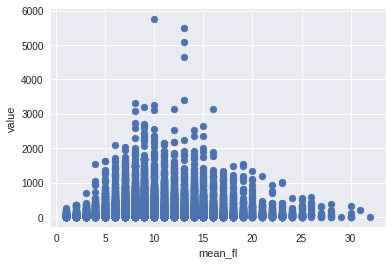

In [22]:
plt.scatter(train.mean_fl, train.value)
plt.xlabel("mean_fl")
plt.ylabel("value")

In [12]:
train['year'] = train.date1.str[:4].astype(int)

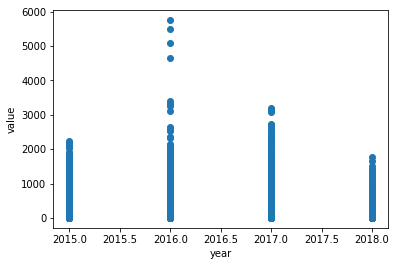

In [18]:
plt.scatter(train.year, train.value)
plt.xlabel("year")
plt.ylabel("value")

In [21]:
train['month'] = train.date1.str[5:7].astype(int)

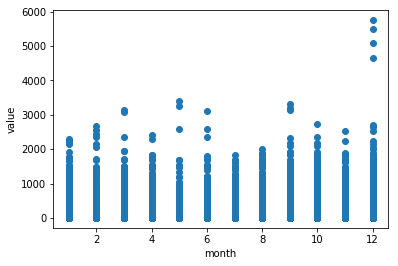

In [23]:
plt.scatter(train.month, train.value)
plt.xlabel("month")
plt.ylabel("value")

In [24]:
train['detailed_time'] = train.year + train.month / 12.

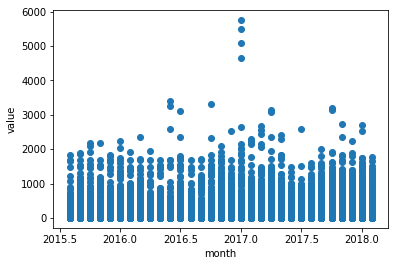

In [26]:
plt.scatter(train.detailed_time, train.value)
plt.xlabel("month")
plt.ylabel("value")